# CELL 1: Setup and Imports

In [1]:
"""
Brain-to-Text 2025 Data Explorer
Simple interface for loading and visualizing neural data samples in Google Colab

Run this cell first to import all necessary libraries and define constants.
"""

import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Phoneme mapping from competition
LOGIT_TO_PHONEME = [
    'BLANK',    # "BLANK" = CTC blank symbol
    'AA', 'AE', 'AH', 'AO', 'AW',
    'AY', 'B', 'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G',
    'HH', 'IH', 'IY', 'JH', 'K',
    'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH',
    'T', 'TH', 'UH', 'UW', 'V',
    'W', 'Y', 'Z', 'ZH',
    ' | ',    # "|" = silence token
]

print("✅ Libraries imported successfully!")
print("✅ Constants defined!")
print("\nNext: Run Cell 2 to define the data explorer class")


✅ Libraries imported successfully!
✅ Constants defined!

Next: Run Cell 2 to define the data explorer class


# CELL 2: Data Explorer Class Definition

In [2]:
"""
Define the Brain2TextDataExplorer class with all methods for loading,
processing, and visualizing the neural data.

Run this cell after Cell 1 to define the main data explorer functionality.
"""

class Brain2TextDataExplorer:
    """
    Simple data explorer for Brain-to-Text 2025 competition data
    """

    def __init__(self, data_dir: str = "/content/brain2text_data"):
        """
        Initialize the data explorer

        Args:
            data_dir: Directory containing the .hdf5 files
        """
        self.data_dir = Path(data_dir)
        self.data = None
        self.train_indices = None
        self.val_indices = None
        self.test_indices = None

    def load_data(self, file_pattern: str = "*.hdf5", include_test: bool = True) -> Dict:
        """
        Load all .hdf5 files from the data directory (searches recursively)

        Args:
            file_pattern: Pattern to match data files
            include_test: If False, skip samples without labels (likely test data)

        Returns:
            Dictionary containing all loaded data
        """
        print("Loading Brain-to-Text 2025 data...")

        data = {
            'neural_features': [],
            'n_time_steps': [],
            'seq_class_ids': [],
            'seq_len': [],
            'transcriptions': [],
            'sentence_label': [],
            'session': [],
            'block_num': [],
            'trial_num': [],
        }

        # Search for .hdf5 files recursively (handles nested folder structure)
        hdf5_files = list(self.data_dir.rglob(file_pattern))  # rglob for recursive search

        if not hdf5_files:
            # Try looking in common subdirectories
            common_subdirs = ['hdf5_data_final', 'data', 'hdf5_data']
            for subdir in common_subdirs:
                subdir_path = self.data_dir / subdir
                if subdir_path.exists():
                    print(f"Searching in subdirectory: {subdir}")
                    hdf5_files = list(subdir_path.rglob(file_pattern))
                    if hdf5_files:
                        break

        if not hdf5_files:
            print(f"No .hdf5 files found in {self.data_dir} or its subdirectories")
            print("Directory structure:")
            for item in self.data_dir.iterdir():
                if item.is_dir():
                    print(f"  📁 {item.name}/")
                    # Show first few items in each subdirectory
                    sub_items = list(item.iterdir())[:3]
                    for sub_item in sub_items:
                        print(f"    📄 {sub_item.name}")
                    if len(list(item.iterdir())) > 3:
                        print(f"    ... and {len(list(item.iterdir())) - 3} more items")
                else:
                    print(f"  📄 {item.name}")
            return data

        print(f"Found {len(hdf5_files)} .hdf5 files")

        # Track statistics
        total_samples = 0
        samples_with_labels = 0
        samples_without_labels = 0

        # Load each file
        for file_path in hdf5_files:
            print(f"Loading {file_path.name}...")
            file_data = self._load_single_file(file_path)

            # Check each sample for labels and filter if requested
            for i in range(len(file_data['neural_features'])):
                total_samples += 1
                has_sentence_label = (file_data['sentence_label'][i] is not None and
                                    len(str(file_data['sentence_label'][i]).strip()) > 0)
                has_transcription = (file_data['transcriptions'][i] is not None and
                                   len(str(file_data['transcriptions'][i]).strip()) > 0)

                if has_sentence_label or has_transcription:
                    samples_with_labels += 1
                    # Always include samples with labels
                    for key in data.keys():
                        data[key].append(file_data[key][i])
                else:
                    samples_without_labels += 1
                    if include_test:
                        # Include test samples (without labels) if requested
                        for key in data.keys():
                            data[key].append(file_data[key][i])

        print(f"\n📊 Data Loading Summary:")
        print(f"  Total samples found: {total_samples}")
        print(f"  Samples with labels: {samples_with_labels} (likely train/val)")
        print(f"  Samples without labels: {samples_without_labels} (likely test)")
        print(f"  Samples loaded: {len(data['neural_features'])}")

        if not include_test and samples_without_labels > 0:
            print(f"  ⚠️  Skipped {samples_without_labels} test samples (no labels)")
            print(f"  💡 Use load_data(include_test=True) to include test data")

        self.data = data
        return data

    def _load_single_file(self, file_path: Path) -> Dict:
        """Load a single .hdf5 file"""
        data = {
            'neural_features': [],
            'n_time_steps': [],
            'seq_class_ids': [],
            'seq_len': [],
            'transcriptions': [],
            'sentence_label': [],
            'session': [],
            'block_num': [],
            'trial_num': [],
        }

        with h5py.File(file_path, 'r') as f:
            keys = list(f.keys())

            for key in keys:
                g = f[key]

                neural_features = g['input_features'][:]
                n_time_steps = g.attrs['n_time_steps']
                seq_class_ids = g['seq_class_ids'][:] if 'seq_class_ids' in g else None
                seq_len = g.attrs['seq_len'] if 'seq_len' in g.attrs else None
                transcription = g['transcription'][:] if 'transcription' in g else None
                sentence_label = g.attrs['sentence_label'][:] if 'sentence_label' in g.attrs else None
                session = g.attrs['session']
                block_num = g.attrs['block_num']
                trial_num = g.attrs['trial_num']

                data['neural_features'].append(neural_features)
                data['n_time_steps'].append(n_time_steps)
                data['seq_class_ids'].append(seq_class_ids)
                data['seq_len'].append(seq_len)
                data['transcriptions'].append(transcription)
                data['sentence_label'].append(sentence_label)
                data['session'].append(session)
                data['block_num'].append(block_num)
                data['trial_num'].append(trial_num)

        return data

    def create_splits(self, train_ratio: float = 0.7, val_ratio: float = 0.15,
                     test_ratio: float = 0.15, random_seed: int = 42) -> Tuple[List, List, List]:
        """
        Create train/validation/test splits

        Args:
            train_ratio: Proportion for training set
            val_ratio: Proportion for validation set
            test_ratio: Proportion for test set
            random_seed: Random seed for reproducibility

        Returns:
            Tuple of (train_indices, val_indices, test_indices)
        """
        if self.data is None:
            raise ValueError("Data not loaded. Call load_data() first.")

        # Check ratios sum to 1
        if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
            raise ValueError("Ratios must sum to 1.0")

        n_samples = len(self.data['neural_features'])
        indices = np.arange(n_samples)

        # Shuffle indices
        np.random.seed(random_seed)
        np.random.shuffle(indices)

        # Calculate split points
        train_end = int(n_samples * train_ratio)
        val_end = train_end + int(n_samples * val_ratio)

        # Create splits
        self.train_indices = indices[:train_end].tolist()
        self.val_indices = indices[train_end:val_end].tolist()
        self.test_indices = indices[val_end:].tolist()

        print(f"Created splits:")
        print(f"  Train: {len(self.train_indices)} samples")
        print(f"  Val:   {len(self.val_indices)} samples")
        print(f"  Test:  {len(self.test_indices)} samples")

        return self.train_indices, self.val_indices, self.test_indices

    def get_sample_info(self, sample_idx: int, debug: bool = False) -> Dict:
        """
        Get detailed information about a specific sample

        Args:
            sample_idx: Index of the sample to inspect
            debug: If True, print debug information about data formats

        Returns:
            Dictionary with sample information
        """
        if self.data is None:
            raise ValueError("Data not loaded. Call load_data() first.")

        if sample_idx >= len(self.data['neural_features']):
            raise ValueError(f"Sample index {sample_idx} out of range (max: {len(self.data['neural_features'])-1})")

        if debug:
            print(f"Debug info for sample {sample_idx}:")
            print(f"  transcription type: {type(self.data['transcriptions'][sample_idx])}")
            print(f"  sentence_label type: {type(self.data['sentence_label'][sample_idx])}")
            if self.data['sentence_label'][sample_idx] is not None:
                print(f"  sentence_label value: {repr(self.data['sentence_label'][sample_idx])}")

        # Extract transcription if available
        transcription = None
        if self.data['transcriptions'][sample_idx] is not None:
            trans_data = self.data['transcriptions'][sample_idx]
            if isinstance(trans_data, str):
                transcription = trans_data
            else:
                # Handle bytes/array format
                try:
                    end_idx = np.where(trans_data == 0)[0]
                    if len(end_idx) > 0:
                        end_idx = end_idx[0]
                        transcription = ''.join([chr(c) for c in trans_data[:end_idx]])
                    else:
                        transcription = ''.join([chr(c) for c in trans_data if c != 0])
                except Exception as e:
                    if debug:
                        print(f"  Error parsing transcription: {e}")
                    transcription = str(trans_data)  # Fallback

        # Extract sentence label if available
        sentence_label = None
        if self.data['sentence_label'][sample_idx] is not None:
            label_data = self.data['sentence_label'][sample_idx]
            try:
                if isinstance(label_data, str):
                    sentence_label = label_data
                elif isinstance(label_data, bytes):
                    sentence_label = label_data.decode('utf-8').rstrip('\x00')
                else:
                    # Handle array format
                    sentence_label = ''.join([chr(c) for c in label_data if c != 0])
            except Exception as e:
                if debug:
                    print(f"  Error parsing sentence_label: {e}")
                sentence_label = str(label_data)  # Fallback

        # Convert phoneme sequence to readable format
        phoneme_sequence = None
        if self.data['seq_class_ids'][sample_idx] is not None:
            phoneme_ids = self.data['seq_class_ids'][sample_idx]
            phoneme_sequence = [LOGIT_TO_PHONEME[pid] for pid in phoneme_ids if pid < len(LOGIT_TO_PHONEME)]

        # Determine split
        split = "Unknown"
        if self.train_indices and sample_idx in self.train_indices:
            split = "Train"
        elif self.val_indices and sample_idx in self.val_indices:
            split = "Validation"
        elif self.test_indices and sample_idx in self.test_indices:
            split = "Test"

        neural_data = self.data['neural_features'][sample_idx]

        info = {
            'sample_idx': sample_idx,
            'split': split,
            'neural_shape': neural_data.shape,
            'n_time_steps': self.data['n_time_steps'][sample_idx],
            'n_channels': neural_data.shape[0],
            'duration_ms': neural_data.shape[1] * 20,  # 20ms bins
            'transcription': transcription,
            'sentence_label': sentence_label,
            'phoneme_sequence': phoneme_sequence,
            'seq_len': self.data['seq_len'][sample_idx],
            'session': self.data['session'][sample_idx],
            'block_num': self.data['block_num'][sample_idx],
            'trial_num': self.data['trial_num'][sample_idx],
        }

        return info

    def visualize_sample(self, sample_idx: int, figsize: Tuple[int, int] = (15, 10),
                        show_channels: Optional[List[int]] = None) -> None:
        """
        Visualize a neural data sample as a matrix heatmap

        Args:
            sample_idx: Index of sample to visualize
            figsize: Figure size (width, height)
            show_channels: List of specific channels to show (None = all channels)
        """
        if self.data is None:
            raise ValueError("Data not loaded. Call load_data() first.")

        # Get sample info
        info = self.get_sample_info(sample_idx)
        neural_data = self.data['neural_features'][sample_idx]

        # Select channels to display
        if show_channels is not None:
            neural_data = neural_data[show_channels, :]
            channel_labels = [f"Ch {i}" for i in show_channels]
        else:
            channel_labels = [f"Ch {i}" for i in range(neural_data.shape[0])]

        # Create the plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[3, 1])

        # Main heatmap
        im = ax1.imshow(neural_data, aspect='auto', cmap='viridis', interpolation='nearest')
        ax1.set_title(f'Neural Activity Matrix - Sample {sample_idx}', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time Steps (20ms bins)')
        ax1.set_ylabel('Neural Channels (512 features)')

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax1)
        cbar.set_label('Neural Activity', rotation=270, labelpad=20)

        # Add channel region annotations (based on competition description)
        channel_regions = [
            (0, 64, 'Ventral 6v (Threshold)'),
            (65, 128, 'Area 4 (Threshold)'),
            (129, 192, '55b (Threshold)'),
            (193, 256, 'Dorsal 6v (Threshold)'),
            (257, 320, 'Ventral 6v (Power)'),
            (321, 384, 'Area 4 (Power)'),
            (385, 448, '55b (Power)'),
            (449, 512, 'Dorsal 6v (Power)')
        ]

        if show_channels is None:  # Only show region lines for full view
            for start, end, label in channel_regions:
                ax1.axhline(y=start-0.5, color='red', linestyle='--', alpha=0.7, linewidth=1)
                ax1.text(-10, (start+end)/2, label, rotation=90, va='center', ha='right', fontsize=8)

        # Sample information panel
        ax2.axis('off')
        info_text = f"""
Sample Information:
• Index: {info['sample_idx']} | Split: {info['split']} | Shape: {info['neural_shape']}
• Duration: {info['duration_ms']} ms ({info['n_time_steps']} time steps)
• Session: {info['session']} | Block: {info['block_num']} | Trial: {info['trial_num']}
• Sentence: "{info['sentence_label'] or 'N/A'}"
• Transcription: "{info['transcription'] or 'N/A'}"
• Phonemes: {' '.join(info['phoneme_sequence'][:10]) + '...' if info['phoneme_sequence'] and len(info['phoneme_sequence']) > 10 else ' '.join(info['phoneme_sequence'] or ['N/A'])}
        """.strip()

        ax2.text(0.02, 0.95, info_text, transform=ax2.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

        plt.tight_layout()
        plt.show()

        return info

    def print_dataset_summary(self) -> None:
        """Print a summary of the loaded dataset"""
        if self.data is None:
            print("No data loaded. Call load_data() first.")
            return

        n_samples = len(self.data['neural_features'])

        # Calculate statistics
        time_steps = [self.data['n_time_steps'][i] for i in range(n_samples)]
        durations_ms = [t * 20 for t in time_steps]  # 20ms bins

        print("=" * 60)
        print("BRAIN-TO-TEXT 2025 DATASET SUMMARY")
        print("=" * 60)
        print(f"Total samples: {n_samples}")
        print(f"Neural features per sample: 512 (256 electrodes × 2 features)")
        print(f"Time resolution: 20ms bins")
        print(f"Duration range: {min(durations_ms):.0f} - {max(durations_ms):.0f} ms")
        print(f"Average duration: {np.mean(durations_ms):.0f} ms")

        if self.train_indices is not None:
            print(f"\nData splits:")
            print(f"  Train: {len(self.train_indices)} samples ({len(self.train_indices)/n_samples*100:.1f}%)")
            print(f"  Val:   {len(self.val_indices)} samples ({len(self.val_indices)/n_samples*100:.1f}%)")
            print(f"  Test:  {len(self.test_indices)} samples ({len(self.test_indices)/n_samples*100:.1f}%)")

        # Session information
        sessions = list(set(self.data['session']))
        print(f"\nSessions: {len(sessions)} sessions spanning 20 months")
        print(f"Blocks per session: varies")

        print("\nNeural feature organization (512 features):")
        print("  Channels 0-63:   Ventral 6v threshold crossings")
        print("  Channels 64-127: Area 4 threshold crossings")
        print("  Channels 128-191: 55b threshold crossings")
        print("  Channels 192-255: Dorsal 6v threshold crossings")
        print("  Channels 256-319: Ventral 6v spike band power")
        print("  Channels 320-383: Area 4 spike band power")
        print("  Channels 384-447: 55b spike band power")
        print("  Channels 448-511: Dorsal 6v spike band power")
        print("=" * 60)

print("✅ Brain2TextDataExplorer class defined successfully!")
print("\nNext: Run Cell 3 to initialize and use the data explorer")

✅ Brain2TextDataExplorer class defined successfully!

Next: Run Cell 3 to initialize and use the data explorer


# CELL 3: Initialize and Use Data Explorer

In [3]:
"""
Initialize the data explorer, load data, create splits, and start exploring!

Modify the data_dir path to point to your .hdf5 files location.
Uncomment and run the sections you want to use.
"""

def interactive_sample_explorer(explorer: Brain2TextDataExplorer) -> None:
    """
    Interactive function for exploring samples in Colab

    Args:
        explorer: Initialized Brain2TextDataExplorer instance
    """
    if explorer.data is None:
        print("Please load data first using explorer.load_data()")
        return

    n_samples = len(explorer.data['neural_features'])
    print(f"Interactive Sample Explorer")
    print(f"Available samples: 0 to {n_samples-1}")
    print("Enter sample index to visualize, or 'q' to quit")

    while True:
        try:
            user_input = input(f"\nEnter sample index (0-{n_samples-1}) or 'q' to quit: ").strip()

            if user_input.lower() == 'q':
                print("Goodbye!")
                break

            sample_idx = int(user_input)

            if 0 <= sample_idx < n_samples:
                print(f"\nVisualizing sample {sample_idx}...")
                explorer.visualize_sample(sample_idx)
            else:
                print(f"Invalid index. Please enter a number between 0 and {n_samples-1}")

        except ValueError:
            print("Invalid input. Please enter a number or 'q' to quit.")
        except KeyboardInterrupt:
            print("\nGoodbye!")
            break

#Use

In [4]:
# ----------------------------------------------------------------------------
# STEP 1: Download Data from Dryad (OPTIONAL - Run once per session)
# ----------------------------------------------------------------------------
def download_brain2text_data(data_dir="/content/brain2text_data"):
    """Download Brain-to-Text 2025 data directly from Dryad repository"""
    import urllib.request
    import json
    import zipfile
    import os
    import sys

    # Create data directory
    os.makedirs(data_dir, exist_ok=True)

    print("🌐 Downloading Brain-to-Text 2025 data from Dryad...")

    DRYAD_DOI = "10.5061/dryad.dncjsxm85"
    DRYAD_ROOT = "https://datadryad.org"
    urlified_doi = DRYAD_DOI.replace("/", "%2F")

    # Get file list from Dryad API
    versions_url = f"{DRYAD_ROOT}/api/v2/datasets/doi:{urlified_doi}/versions"
    with urllib.request.urlopen(versions_url) as response:
        versions_info = json.loads(response.read().decode())

    files_url_path = versions_info["_embedded"]["stash:versions"][-1]["_links"]["stash:files"]["href"]
    files_url = f"{DRYAD_ROOT}{files_url_path}"
    with urllib.request.urlopen(files_url) as response:
        files_info = json.loads(response.read().decode())

    file_infos = files_info["_embedded"]["stash:files"]

    # Download each file
    for file_info in file_infos:
        filename = file_info["path"]
        if filename == "README.md":
            continue

        download_path = file_info["_links"]["stash:download"]["href"]
        download_url = f"{DRYAD_ROOT}{download_path}"
        download_to_filepath = os.path.join(data_dir, filename)

        print(f"📥 Downloading {filename}...")
        urllib.request.urlretrieve(download_url, download_to_filepath)

        # Unzip if it's a zip file
        if file_info["mimeType"] == "application/zip":
            print(f"📦 Extracting {filename}...")
            with zipfile.ZipFile(download_to_filepath, "r") as zf:
                zf.extractall(data_dir)

    print(f"✅ Download complete! Data saved to: {data_dir}")
    return data_dir

# Uncomment the next line to download data (run once per Colab session)
data_dir = download_brain2text_data("/content/brain2text_data")

🌐 Downloading Brain-to-Text 2025 data from Dryad...
📥 Downloading t15_copyTask_neuralData.zip...
📦 Extracting t15_copyTask_neuralData.zip...
📥 Downloading t15_copyTask.pkl...
📥 Downloading t15_personalUse.pkl...
📥 Downloading t15_pretrained_rnn_baseline.zip...
📦 Extracting t15_pretrained_rnn_baseline.zip...
✅ Download complete! Data saved to: /content/brain2text_data


In [5]:
# ----------------------------------------------------------------------------
# STEP 2: Initialize Explorer (REQUIRED)
# ----------------------------------------------------------------------------
# Use the same directory where data was downloaded
data_dir = "/content/brain2text_data"  # Change this if you used a different path above
explorer = Brain2TextDataExplorer(data_dir)
print(f"✅ Explorer initialized with data directory: {data_dir}")

✅ Explorer initialized with data directory: /content/brain2text_data


In [6]:
# ----------------------------------------------------------------------------
# STEP 3: Load Data (REQUIRED)
# ----------------------------------------------------------------------------
# Option A: Load only train/val data (samples with labels) - RECOMMENDED for exploration
# data = explorer.load_data(include_test=False)

# Option B: Load all data including test samples (no labels for test samples)
# data = explorer.load_data(include_test=True)

# Option C: Load with default settings (includes test data)
# data = explorer.load_data()

Loading Brain-to-Text 2025 data...
Found 127 .hdf5 files
Loading data_test.hdf5...
Loading data_train.hdf5...
Loading data_val.hdf5...
Loading data_test.hdf5...
Loading data_train.hdf5...
Loading data_val.hdf5...
Loading data_test.hdf5...
Loading data_train.hdf5...
Loading data_val.hdf5...
Loading data_train.hdf5...
Loading data_test.hdf5...
Loading data_train.hdf5...
Loading data_val.hdf5...
Loading data_test.hdf5...
Loading data_train.hdf5...
Loading data_val.hdf5...
Loading data_test.hdf5...
Loading data_train.hdf5...
Loading data_val.hdf5...
Loading data_test.hdf5...
Loading data_train.hdf5...
Loading data_val.hdf5...
Loading data_test.hdf5...
Loading data_train.hdf5...
Loading data_val.hdf5...
Loading data_test.hdf5...
Loading data_train.hdf5...
Loading data_val.hdf5...
Loading data_test.hdf5...
Loading data_train.hdf5...
Loading data_val.hdf5...
Loading data_test.hdf5...
Loading data_train.hdf5...
Loading data_val.hdf5...
Loading data_test.hdf5...
Loading data_train.hdf5...
Loadi

In [7]:
# ----------------------------------------------------------------------------
# STEP 4: Create Train/Val/Test Splits (OPTIONAL)
# ----------------------------------------------------------------------------
# Uncomment to create data splits
train_idx, val_idx, test_idx = explorer.create_splits(train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

Created splits:
  Train: 7663 samples
  Val:   1642 samples
  Test:  1643 samples


Interactive Sample Explorer
Available samples: 0 to 10947
Enter sample index to visualize, or 'q' to quit

Visualizing sample 500...


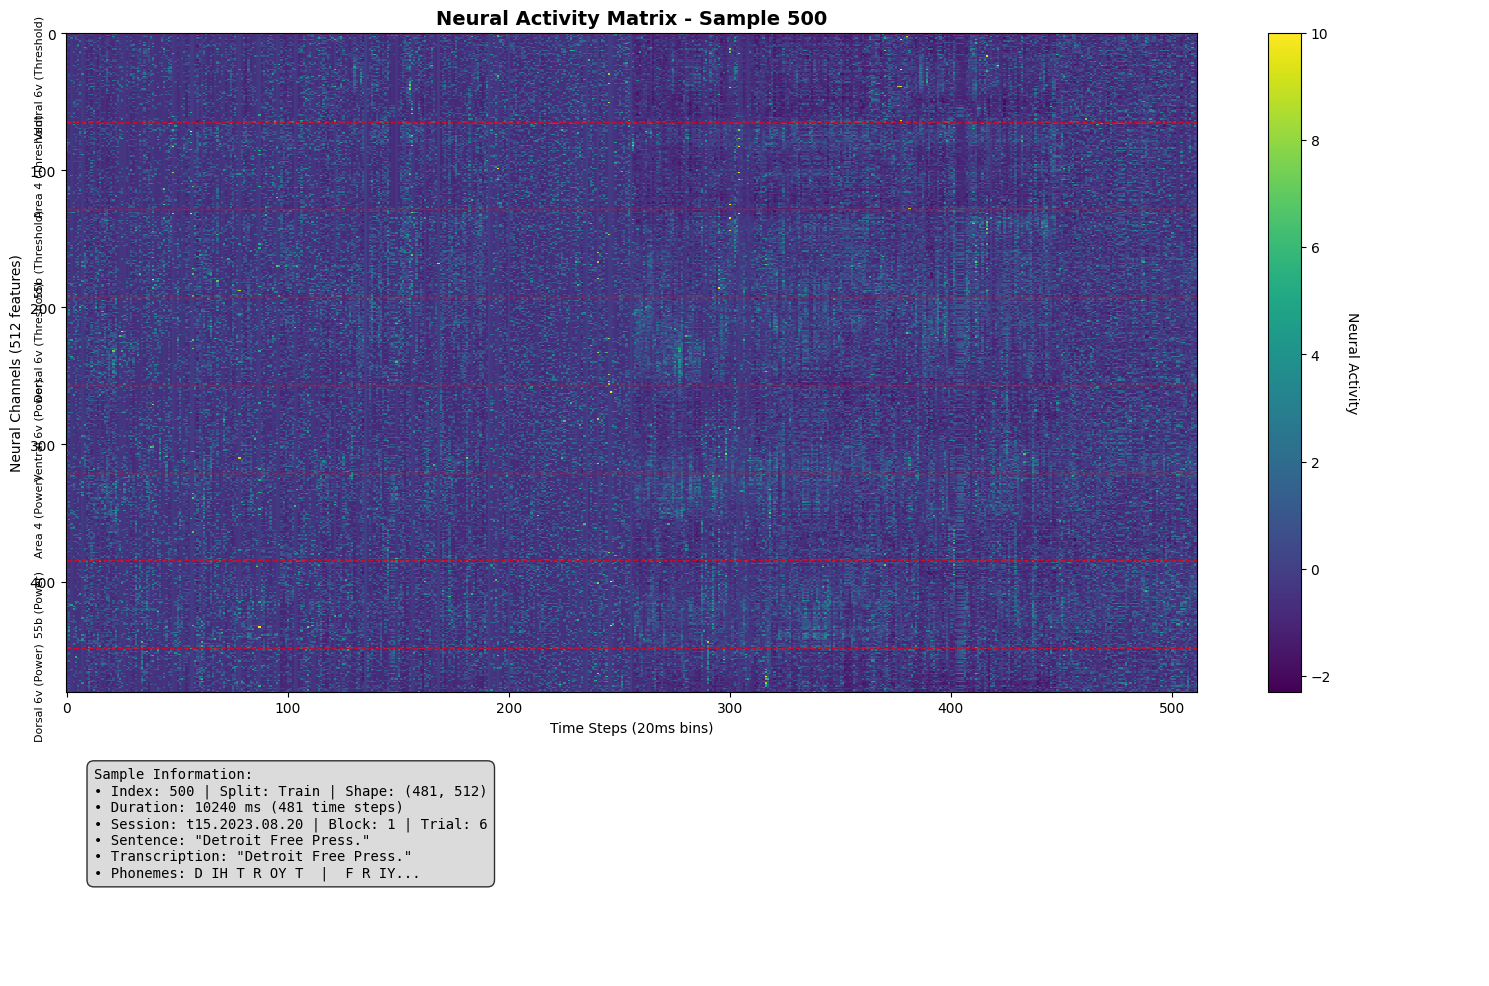

In [ ]:
# ----------------------------------------------------------------------------
# STEP 5: Explore Your Data (CHOOSE YOUR ADVENTURE!)
# ----------------------------------------------------------------------------

# Option A: Print dataset summary
# explorer.print_dataset_summary()

# Option B: Visualize specific samples
# explorer.visualize_sample(0)      # First sample
# explorer.visualize_sample(100)    # Sample 100
# explorer.visualize_sample(500)    # Sample 500

# Option C: Interactive exploration (run this for manual browsing)
interactive_sample_explorer(explorer)

# Option D: Get detailed info about a sample without plotting
# info = explorer.get_sample_info(0)
# print(info)

print("\n" + "="*60)
print("🧠 BRAIN-TO-TEXT 2025 DATA EXPLORER READY!")
print("="*60)
print("📋 QUICK START GUIDE:")
print("1. Uncomment: data_dir = download_brain2text_data()  # Downloads data")
print("2. Uncomment: data = explorer.load_data()           # Loads .hdf5 files")
print("3. Uncomment: explorer.print_dataset_summary()      # Shows overview")
print("4. Uncomment: explorer.visualize_sample(0)          # Plots sample")
print("5. Uncomment: interactive_sample_explorer(explorer) # Browse samples")
print("\n💡 TIP: Run step 1 once per Colab session to download data!")
print("💡 TIP: Uncomment one section at a time and run the cell!")
print("="*60)